In [1]:
%matplotlib inline
import os
from tensorflow.keras import layers, optimizers, regularizers, callbacks, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2, os
import telegram_send
plt.style.use('seaborn-white')

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

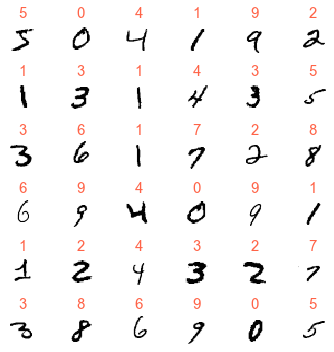

In [3]:
f, axes = plt.subplots(6, 6, figsize = (5, 5))
for i in range(36):
    axes[i//6, i%6].imshow(x_train[i].reshape(28, 28))
    axes[i//6, i%6].axis('off')
    axes[i//6, i%6].set_title(y_train[i], color = 'tomato').set_size(15)
plt.tight_layout()

In [4]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [5]:
callback_is_nan = callbacks.TerminateOnNaN()
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        display.clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
plot_losses = PlotLosses()

In [6]:
def plot_accuracy(history):
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    accuracy = history.history['accuracy']
    loss = history.history['loss']
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    print('Training accuracy: {:.{}f}'.format(np.max(accuracy), 3))
    print('Training loss: {:.{}f}'.format(np.max(loss), 3))
    print('Validation accuracy: {:.{}f}'.format(np.max(val_accuracy), 3))
    print('Validation loss: {:.{}f}'.format(np.max(val_loss), 3))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set(ylabel = 'accuracy', xlabel = 'Epoch')
    axes[0].legend(['Train', 'Test'], loc='upper left')
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set(ylabel = 'Loss', xlabel = 'Epoch')
    axes[1].legend(['Train', 'Test'], loc='upper left')

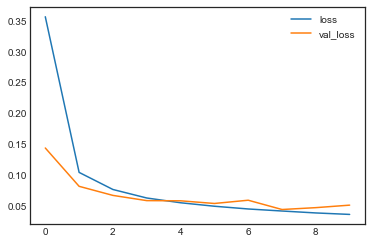

60000/60000 [==============================] - 2s 40us/sample - loss: 0.0361 - accuracy: 0.9894 - val_loss: 0.0511 - val_accuracy: 0.9841
Training accuracy: 0.989
Training loss: 0.357
Validation accuracy: 0.986
Validation loss: 0.144
Wall time: 27.7 s


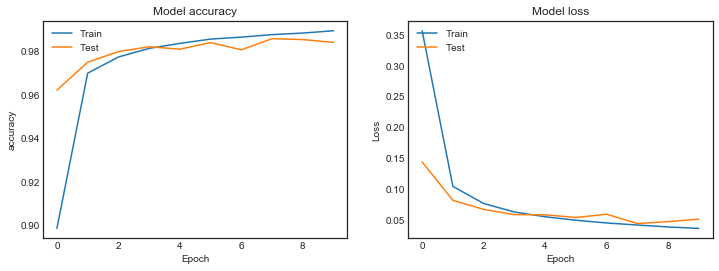

In [7]:
%%time

inputs = layers.Input(input_shape)

x = layers.Conv2D(8, 3, padding = 'same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(16, 3, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(10, activation='softmax')(x)

model = Model(inputs, x)
model.compile(optimizer=optimizers.RMSprop(lr=5e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
          x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[plot_losses, callback_is_nan])
plot_accuracy(history)

Elucidated from [here](https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md)

In [8]:
def visualize(model, image):
    model_layers = model.layers
    # Extracts the outputs
    layer_outputs = [layer.output for layer in model.layers]
    # Creates a model that will return these outputs, given the model input
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    # get activations
    activations = activation_model.predict(image)
    images_per_row = 4
    for layer, layer_activation in zip(model_layers, activations): # Displays the feature maps
        if not isinstance(layer, layers.Conv2D):
            continue
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                # Post-processes the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer.name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')
    return [layer.name for layer in model.layers if isinstance(layer, layers.Conv2D)]

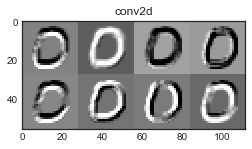

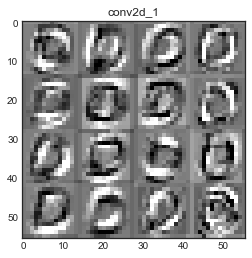

In [9]:
index = 10
image = x_test[index:index+1]
names = visualize(model, image)

In [10]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs[0]],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        # guidedGrads = guidedGrads[0]
        guidedGrads = grads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        # return the resulting heatmap to the calling function
        return 1-heatmap
    def overlay_heatmap(self, heatmap, image, alpha=0.2):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        output = image*(1-alpha) + heatmap.reshape(1, 28, 28, 1)*alpha
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        output = tf.clip_by_value(output, 0, 1).numpy()
        return (heatmap, output)

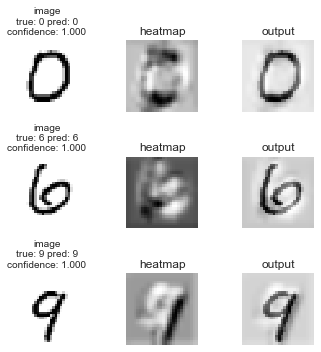

In [11]:
f, axes = plt.subplots(3, 3, figsize=(5, 5))
count = 10
for i in range(9):
    image = x_test[i//3+count:i//3+1+count]
    preds = model.predict(image)
    index = np.argmax(preds[0])
    # initialize our gradient class activation map and build the heatmap
    cam = GradCAM(model, index, names[-1])
    heatmap = cam.compute_heatmap(image)
    (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.5)
    description = 'image\ntrue: {} pred: {}\nconfidence: {:.3f}'.format\
    (np.argmax(y_test[i//3+count]), index, preds[0][index])
    
    axes[i//3, 0].imshow(image.reshape(28, 28))
    axes[i//3, 1].imshow(heatmap.reshape(28, 28))
    axes[i//3, 2].imshow(output.reshape(28, 28))
    axes[i//3, 0].set_title(description).set_size(10)
    axes[i//3, 1].set_title('heatmap')
    axes[i//3, 2].set_title('output')
    axes[i//3, i%3].axis('off')
plt.tight_layout()